In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Monthly_Timeseries.csv", index_col='Month', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,EG_(GWh)
Month,
2010-01-01,2624
2010-02-01,2336
2010-03-01,2432
2010-04-01,2126
2010-05-01,2095


<AxesSubplot:xlabel='Month'>

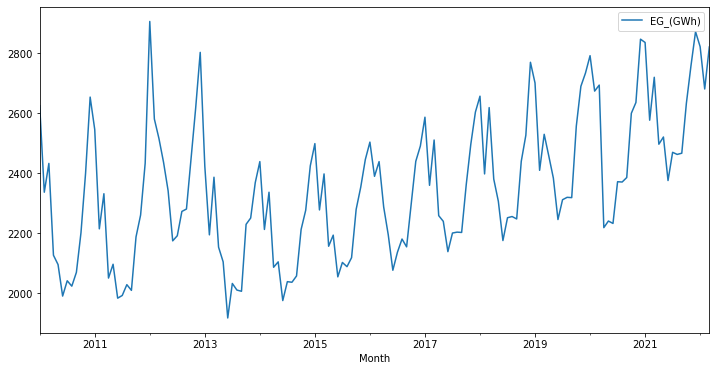

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

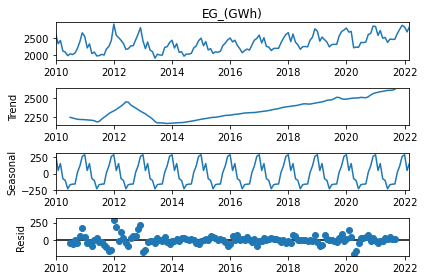

In [6]:
results = seasonal_decompose(df['EG_(GWh)'])
results.plot();

In [7]:
len(df)

147

In [8]:
train = df.iloc[:135]
test = df.iloc[135:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(),df.tail()

(            EG_(GWh)
 Month               
 2010-01-01      2624
 2010-02-01      2336
 2010-03-01      2432
 2010-04-01      2126
 2010-05-01      2095,
             EG_(GWh)
 Month               
 2021-11-01      2757
 2021-12-01      2871
 2022-01-01      2821
 2022-02-01      2680
 2022-03-01      2820)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.71558704],
       [0.42408907],
       [0.52125506],
       [0.21153846],
       [0.18016194],
       [0.07388664],
       [0.12550607],
       [0.10728745],
       [0.15384615],
       [0.28744939]])

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.71558704 0.42408907 0.52125506]
Predict this y: 
 [[0.21153846]]


In [16]:
X.shape

(1, 3, 1)

In [17]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0115
Epoch 2/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0112
Epoch 3/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0109
Epoch 4/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0123
Epoch 5/50
123/123 [==============================] - 1s 9ms/step - loss: 0.0115
Epoch 6/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0110
Epoch 7/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0108
Epoch 8/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0101
Epoch 9/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0107
Epoch 10/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0101
Epoch 11/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0108
Epoch 12/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0103
Epoch 13/50
123/123 [====

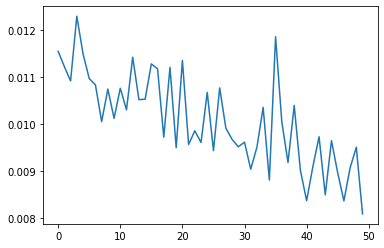

In [51]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [52]:
last_train_batch = scaled_train[-12:]

In [53]:
print(scaled_train.shape)

(135, 1)


In [54]:
print(n_input)
print(n_features)

12
1


In [55]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [56]:
print(last_train_batch)

[[[0.30465587]
  [0.32692308]
  [0.31882591]
  [0.45951417]
  [0.45850202]
  [0.47368421]
  [0.6902834 ]
  [0.72672065]
  [0.9402834 ]
  [0.9291498 ]
  [0.66700405]
  [0.81174089]]]


In [57]:
model.predict(last_train_batch)

array([[0.39330542]], dtype=float32)

In [58]:
scaled_test[0]

array([0.58603239])

In [59]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# print(len(current_batch))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [60]:
test_predictions

[array([0.39330542], dtype=float32),
 array([0.3166343], dtype=float32),
 array([0.25658184], dtype=float32),
 array([0.28293127], dtype=float32),
 array([0.31122348], dtype=float32),
 array([0.37778693], dtype=float32),
 array([0.56453043], dtype=float32),
 array([0.6676323], dtype=float32),
 array([0.66585296], dtype=float32),
 array([0.6887656], dtype=float32),
 array([0.6368611], dtype=float32),
 array([0.63932306], dtype=float32)]

In [61]:
test.head()

,EG_(GWh),Predictions
Month,,
2021-04-01,2440.520544,2440.520544
2021-05-01,2374.424860,2374.424860
2021-06-01,2332.581888,2332.581888
2021-07-01,2393.996219,2393.996219
2021-08-01,2463.063932,2463.063932


In [62]:
true_predictions = scaler.inverse_transform(test_predictions)

In [63]:
test['Predictions'] = true_predictions

<ipython-input-63-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [64]:
test.head()

,EG_(GWh),Predictions
Month,,
2021-04-01,2440.520544,2305.585756
2021-05-01,2374.424860,2229.834686
2021-06-01,2332.581888,2170.502861
2021-07-01,2393.996219,2196.536093
2021-08-01,2463.063932,2224.488795


<AxesSubplot:xlabel='Month'>

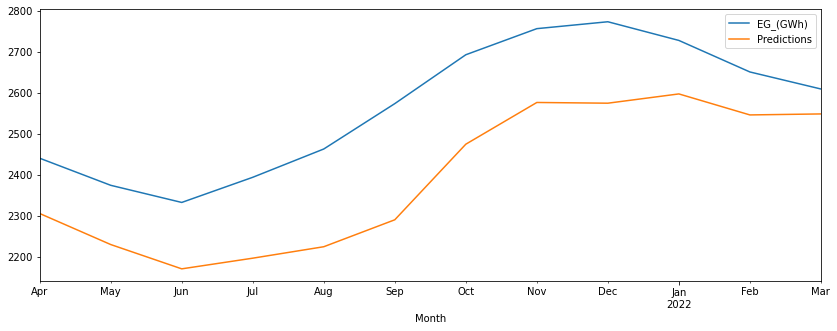

In [65]:
test.plot(figsize=(14,5))

In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['EG_(GWh)'],test['Predictions']))
print(rmse)

180.9974425656647


In [70]:
# Model 2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [121]:
# Defining the model
model = Sequential()

model.add(LSTM(200, activation = 'tanh', input_shape=(n_input, n_features)))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

In [122]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 200)               161600    
                                                                 
 dense_12 (Dense)            (None, 100)               20100     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 181,801
Trainable params: 181,801
Non-trainable params: 0
_________________________________________________________________


In [123]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
123/123 [==============================] - 3s 7ms/step - loss: 0.0471
Epoch 2/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0271
Epoch 3/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0217
Epoch 4/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0187
Epoch 5/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0200
Epoch 6/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0184
Epoch 7/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0176
Epoch 8/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0176
Epoch 9/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0164
Epoch 10/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0158
Epoch 11/50
123/123 [==============================] - 1s 7ms/step - loss: 0.0169
Epoch 12/50
123/123 [==============================] - 1s 8ms/step - loss: 0.0163
Epoch 13/50
123/123 [====

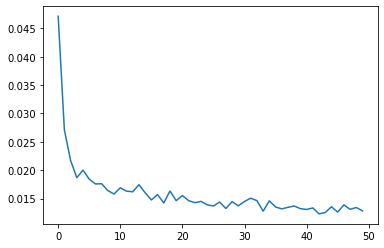

In [124]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [125]:
last_train_batch = scaled_train[-12:]

In [126]:
print(scaled_train.shape)

(135, 1)


In [127]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [128]:
print(last_train_batch)

[[[0.30465587]
  [0.32692308]
  [0.31882591]
  [0.45951417]
  [0.45850202]
  [0.47368421]
  [0.6902834 ]
  [0.72672065]
  [0.9402834 ]
  [0.9291498 ]
  [0.66700405]
  [0.81174089]]]


In [129]:
model.predict(last_train_batch)

array([[0.58880335]], dtype=float32)

In [130]:
scaled_test[0]

array([0.58603239])

In [131]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# print(len(current_batch))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [132]:
test_predictions

[array([0.58880335], dtype=float32),
 array([0.5368779], dtype=float32),
 array([0.51378083], dtype=float32),
 array([0.52962655], dtype=float32),
 array([0.59308755], dtype=float32),
 array([0.6896696], dtype=float32),
 array([0.77228314], dtype=float32),
 array([0.80550516], dtype=float32),
 array([0.7910998], dtype=float32),
 array([0.7426067], dtype=float32),
 array([0.68113345], dtype=float32),
 array([0.62727183], dtype=float32)]

In [133]:
test.head()

,EG_(GWh),Predictions
Month,,
2021-04-01,2440.520544,1917.0
2021-05-01,2374.424860,1917.0
2021-06-01,2332.581888,1917.0
2021-07-01,2393.996219,1917.0
2021-08-01,2463.063932,1917.0


In [134]:
true_predictions = scaler.inverse_transform(test_predictions)

In [135]:
test['Predictions'] = true_predictions

<ipython-input-135-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [143]:
test.head(12)

,EG_(GWh),Predictions
Month,,
2021-04-01,2440.520544,2498.737711
2021-05-01,2374.424860,2447.435336
2021-06-01,2332.581888,2424.615462
2021-07-01,2393.996219,2440.271030
2021-08-01,2463.063932,2502.970503
2021-09-01,2573.818796,2598.393574
2021-10-01,2693.110973,2680.015739
2021-11-01,2756.814981,2712.839095
2021-12-01,2773.652106,2698.606589


<AxesSubplot:xlabel='Month'>

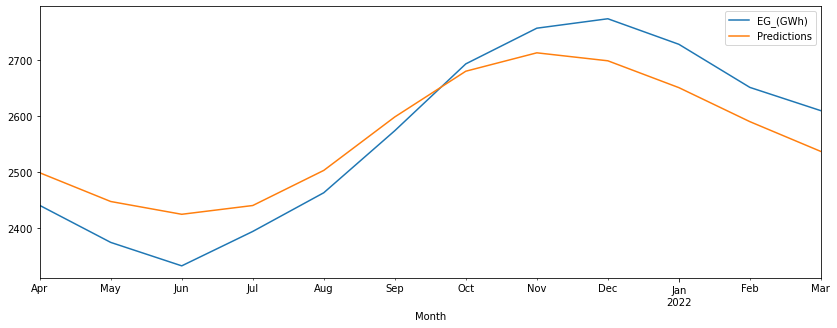

In [137]:
test.plot(figsize=(14,5))

In [140]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

mse = sqrt(mean_squared_error(test['EG_(GWh)'], test['Predictions']))

In [141]:
print(mse)

60.75039691794017


In [142]:
print("Mean Square Error",mse)

Mean Square Error 60.75039691794017


# 